# SpliceVI Test

This notebook will:

1. Load an AnnData containing alternative splicing event (ATSE) counts + mask.  
2. Register it with our SpliceVI model.  
3. Train the model.  
4. Embed cells into a latent space and run UMAP.  
5. Plot and save.

In [1]:
# %% 1. Environment & Imports
import os
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
# Replace with wherever you put your SpliceVI code
# e.g.
# from my_splicevi_package import SpliceVI

print("scvi-tools:", scvi.__version__)

scvi-tools: 1.3.1


## 2. Paths & I/O

In [2]:

ATSE_ANN_DATA = "/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/SIMULATED/simulated_data_2025-03-27.h5ad"
MODEL_DIR     = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models"
FIG_DIR       = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/figures"

## 3. Load AnnData

In [3]:
print("Loading AnnData of ATSEs…")
adata = sc.read_h5ad(ATSE_ANN_DATA)
print(adata)
# we expect:
#   .X holds raw junction counts,
#   .layers['cluster_counts'] holds total cluster counts,
#   .layers['mask'] holds binary mask (1=observed PSI, 0=missing)

Loading AnnData of ATSEs…
AnnData object with n_obs × n_vars = 19942 × 9801
    obs: 'cell_id', 'age', 'batch', 'cell_ontology_class', 'method', 'mouse.id', 'sex', 'tissue', 'old_cell_id_index', 'cell_clean', 'cell_id_index', 'subtissue_clean', 'cell_type_grouped', 'cell_type'
    var: 'junction_id', 'event_id', 'splice_motif', 'label_5_prime', 'label_3_prime', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'non_zero_count_cells', 'non_zero_cell_prop', 'annotation_status_score', 'non_zero_cell_prop_score', 'splice_motif_score', 'junction_id_index', 'chr', 'start', 'end', 'index', '0', '1', 'sample_label', 'difference', 'true_label'
    uns: 'age_colors', 'neighbors', 'pca_explained_variance_ratio', 'tissue_colors', 'umap'
    obsm: 'X_leafletFA', 'X_pca', 'X_umap', 'phi_init_100_waypoints', 'phi_init_30_waypoints'
    varm: 'psi_init_100_waypoints', 'psi_init_30_waypoints'
    layers: 'Cluster_Counts', 'Juncti

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
print(adata.layers["junc_ratio"])

[[0.5        0.05555556 0.44444444 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ... 0.4        0.5        0.1       ]
 [       nan        nan        nan ...        nan        nan        nan]]


In [5]:
# %% Create binary mask from the cell-by-cluster matrix
from scipy import sparse

# 1. Grab your cluster‐counts layer
atse_counts = adata.layers["cell_by_cluster_matrix"]

# 2. If it's sparse, convert to a dense NumPy array
#    .toarray() always works, returning a dense ndarray.
if sparse.issparse(atse_counts):
    atse_arr = atse_counts.toarray()
else:
    atse_arr = atse_counts

# 3. Build mask: 1 wherever count>0, else 0
mask = (atse_arr > 0).astype(np.uint8)
adata.layers["mask"] = mask

print("Added 'mask' layer with shape:", mask.shape)
print("Mask unique values:", np.unique(mask))

# %% Zero out NaNs in the junction‐ratio layer
jr = adata.layers["junc_ratio"]
if sparse.issparse(jr):
    # convert to dense, clean, then back to sparse
    jr_arr = jr.toarray()
    jr_clean = np.nan_to_num(jr_arr, nan=0.0)
    adata.layers["junc_ratio"] = sparse.csr_matrix(jr_clean)
else:
    adata.layers["junc_ratio"] = np.nan_to_num(jr, nan=0.0)

print("Cleaned 'junc_ratio' layer; no more NaNs.")


Added 'mask' layer with shape: (19942, 9801)
Mask unique values: [0 1]
Cleaned 'junc_ratio' layer; no more NaNs.


In [6]:
print(adata.layers["junc_ratio"])

[[0.5        0.05555556 0.44444444 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.4        0.5        0.1       ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## 4. Setup scvi-tools AnnData

In [7]:
scvi.model.SPLICEVI.setup_anndata(
    adata,
    junc_ratio_layer="junc_ratio",                      
    junc_counts_layer="cell_by_junction_matrix",        
    cluster_counts_layer="cell_by_cluster_matrix",      
    psi_mask_layer="mask",                              
    batch_key="mouse.id",                               
)

## 5. Initialize the model

In [8]:
# instantiate with zero labels
model = scvi.model.SPLICEVI(adata)



## 6. Training

In [ ]:
model.train()
model.save(MODEL_DIR, overwrite=True)
print("Model saved to", MODEL_DIR)

/scratch/ipykernel_4111359/3502750969.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/commons/home/svaidyanathan/miniconda3/envs/scv ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU ava

Training:   0%|          | 0/500 [00:00<?, ?it/s]

## 7. Latent embedding + UMAP

AttributeError: 'Axes' object has no attribute 'savefig'

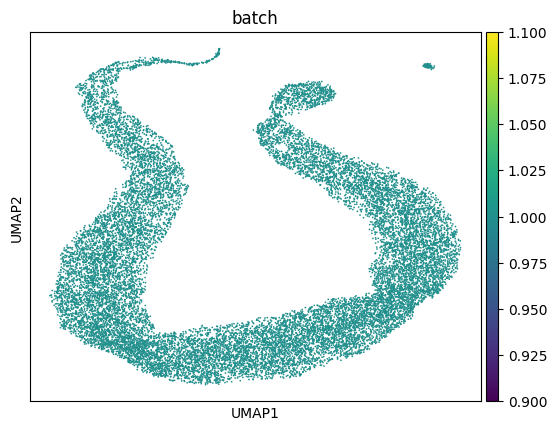

In [ ]:
adata.obsm["X_splicevi"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_splicevi")
sc.tl.umap(adata)


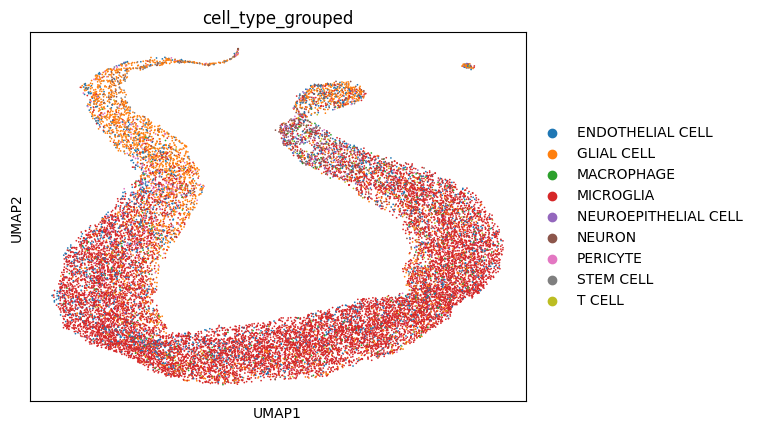

In [10]:
fig = sc.pl.umap(
    adata,
    color=["cell_type_grouped"],
    show=False,
    return_fig=True,
)
fig.savefig(os.path.join(FIG_DIR, "umap_splicevi_batch.png"), dpi=150)

## 8. (Optional) Imputed PSI

In [ ]:
psi_df = model.get_normalized_splicing(return_numpy=False)
psi_df.to_hdf(os.path.join(MODEL_DIR, "imputed_psi.h5"), key="psi", mode="w")